In [33]:
!pip install pyvirtualdisplay

In [22]:
!apt-get update && apt-get install -y swig cmake
!pip install pygame --upgrade
!pip install box2d-py
!pip install gym[box2d]


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,757 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,266 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,092 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease 

In [34]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [35]:
Display(visible=0, size=(900, 500)).start();

tf.random.set_seed(utils.SEED)

In [36]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [7]:
!apt-get update && apt-get install -y swig cmake
!pip install pygame --upgrade
!pip install box2d-py
!pip install gym


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,757 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,266 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 P

In [37]:
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


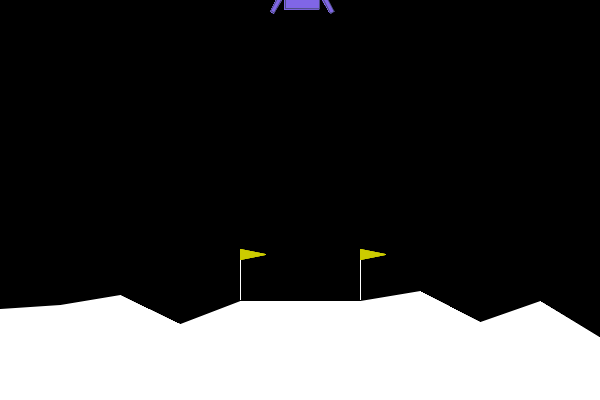

In [38]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [39]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [40]:
initial_state = env.reset()

In [42]:
action = 0

next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: [-0.006 1.407 -0.586 -0.169 0.007 0.133 0.000 0.000]
Action: 0
Next State: [-0.017 1.398 -0.585 -0.221 0.020 0.131 0.000 0.000]
Reward Received: -1.0586747684895386
Episode Terminated: False
Info: {}


In [51]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

q_network.build(input_shape=(None, state_size))
target_q_network.build(input_shape=(None, state_size))


optimizer = Adam(learning_rate=ALPHA)

In [53]:
# UNIT TEST
from public_tests import *

test_network(q_network)
test_network(target_q_network)
test_optimizer(optimizer, ALPHA)

AttributeError: The layer sequential_14 has never been called and thus has no defined input.

In [54]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [55]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    states, actions, rewards, next_states, done_vals = experiences

    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))


    loss = MSE(y_targets, q_values)

    return loss

In [56]:
# UNIT TEST
test_compute_loss(compute_loss)

All tests passed!


In [57]:
@tf.function
def agent_learn(experiences, gamma):

    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)

    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    utils.update_target_network(q_network, target_q_network)

In [58]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100
epsilon = 1.0

memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        state_qn = np.expand_dims(state, axis=0)
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        next_state, reward, done, _ = env.step(action)

        memory_buffer.append(experience(state, action, reward, next_state, done))

        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:

            experiences = utils.get_experiences(memory_buffer)

            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -166.48
Episode 200 | Total point average of the last 100 episodes: -122.29
Episode 300 | Total point average of the last 100 episodes: -58.97
Episode 400 | Total point average of the last 100 episodes: -36.06
Episode 500 | Total point average of the last 100 episodes: 9.26
Episode 600 | Total point average of the last 100 episodes: 129.83
Episode 659 | Total point average of the last 100 episodes: 198.08

Episode 660 | Total point average of the last 100 episodes: 200.97

Environment solved in 660 episodes!

Total Runtime: 1926.89 s (32.11 min)


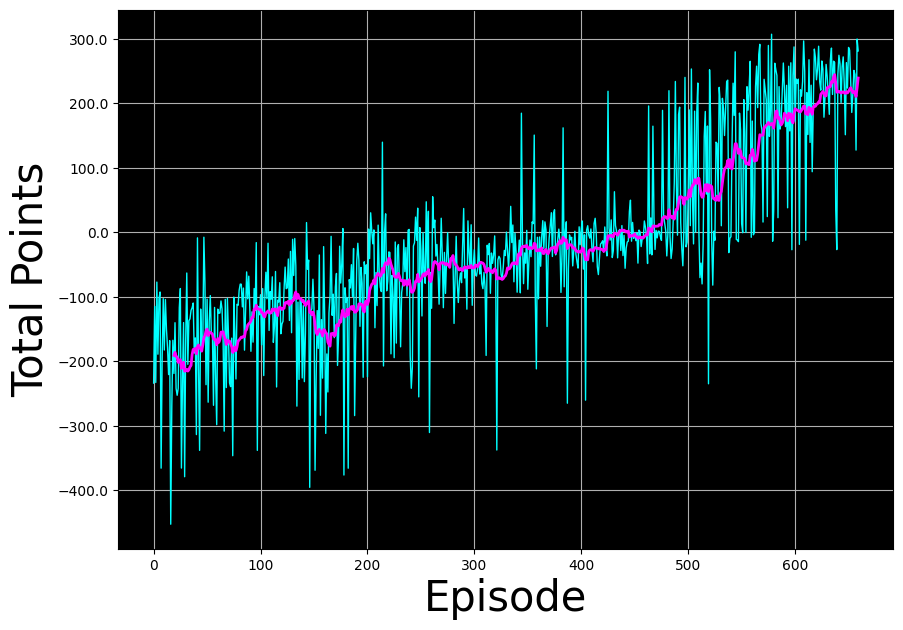

In [59]:
# Plot the point history
utils.plot_history(total_point_history)

In [60]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [61]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('./videos'):
    os.makedirs('./videos')

In [64]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
